# TVB for Epilepsy


### Basic configurations

In [ ]:
# !source activate python2.7.3
print(1)
%matplotlib inline

import os
import warnings
from copy import deepcopy

import numpy as np

from tvb_epilepsy.base.constants.config import Config
from tvb_epilepsy.base.utils.log_error_utils import initialize_logger
from tvb_epilepsy.io.tvb_data_reader import TVBReader
from tvb_epilepsy.io.h5_reader import H5Reader
from tvb_epilepsy.io.h5_writer import H5Writer
from tvb_epilepsy.plot.plotter import Plotter

input_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "CC", "TVB3", "tvb")
head_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "CC", "TVB3", "Head")
output_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "tests")
config = Config(head_folder=input_folder, output_base=output_folder, data_mode="tvb") #, data_mode="java"
config.figures.MATPLOTLIB_BACKEND="inline"
config.figures.SHOW_FLAG=True
logger = initialize_logger(__name__, config.out.FOLDER_LOGS)
tvbreader = TVBReader()
reader = H5Reader()
writer = H5Writer()
plotter = Plotter(config)
print(1)

In [1]:
!source activate python2.7.3

%matplotlib inline

import sys 
stdout = sys.stdout
import os
import numpy as np
from tvb_epilepsy.base.constants.config import Config
from tvb_epilepsy.base.utils.log_error_utils import initialize_logger
from tvb_epilepsy.io.h5_reader import H5Reader
from tvb_epilepsy.io.tvb_data_reader import TVBReader
sys.stdout = stdout
from tvb_epilepsy.io.h5_writer import H5Writer
from tvb_epilepsy.plot.plotter import Plotter

head_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "CC", "TVB3", "Head")
tvb_folder = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "CC", "TVB3", "tvb")
output = os.path.join(os.path.expanduser("~"), 'Dropbox', 'Work', 'VBtech', 'VEP', "results", "tests")
config = Config(head_folder=tvb_folder, output_base=output, data_mode='tvb')
logger = initialize_logger(__name__, config.out.FOLDER_LOGS)
tvb_reader = TVBReader() 
reader = H5Reader()
writer = H5Writer()
config.figures.SHOW_FLAG = True
plotter = Plotter(config)
sys.stdout = stdout

2018-02-22 11:01:06,484 - WARNING - Plotter - Noninteractive matplotlib backend! No highlighting functionality in plots!


2018-02-22 11:01:09,041 - INFO - __main__ - Reading from: /Users/dionperd/Dropbox/Work/VBtech/VEP/results/CC/TVB3/tvb


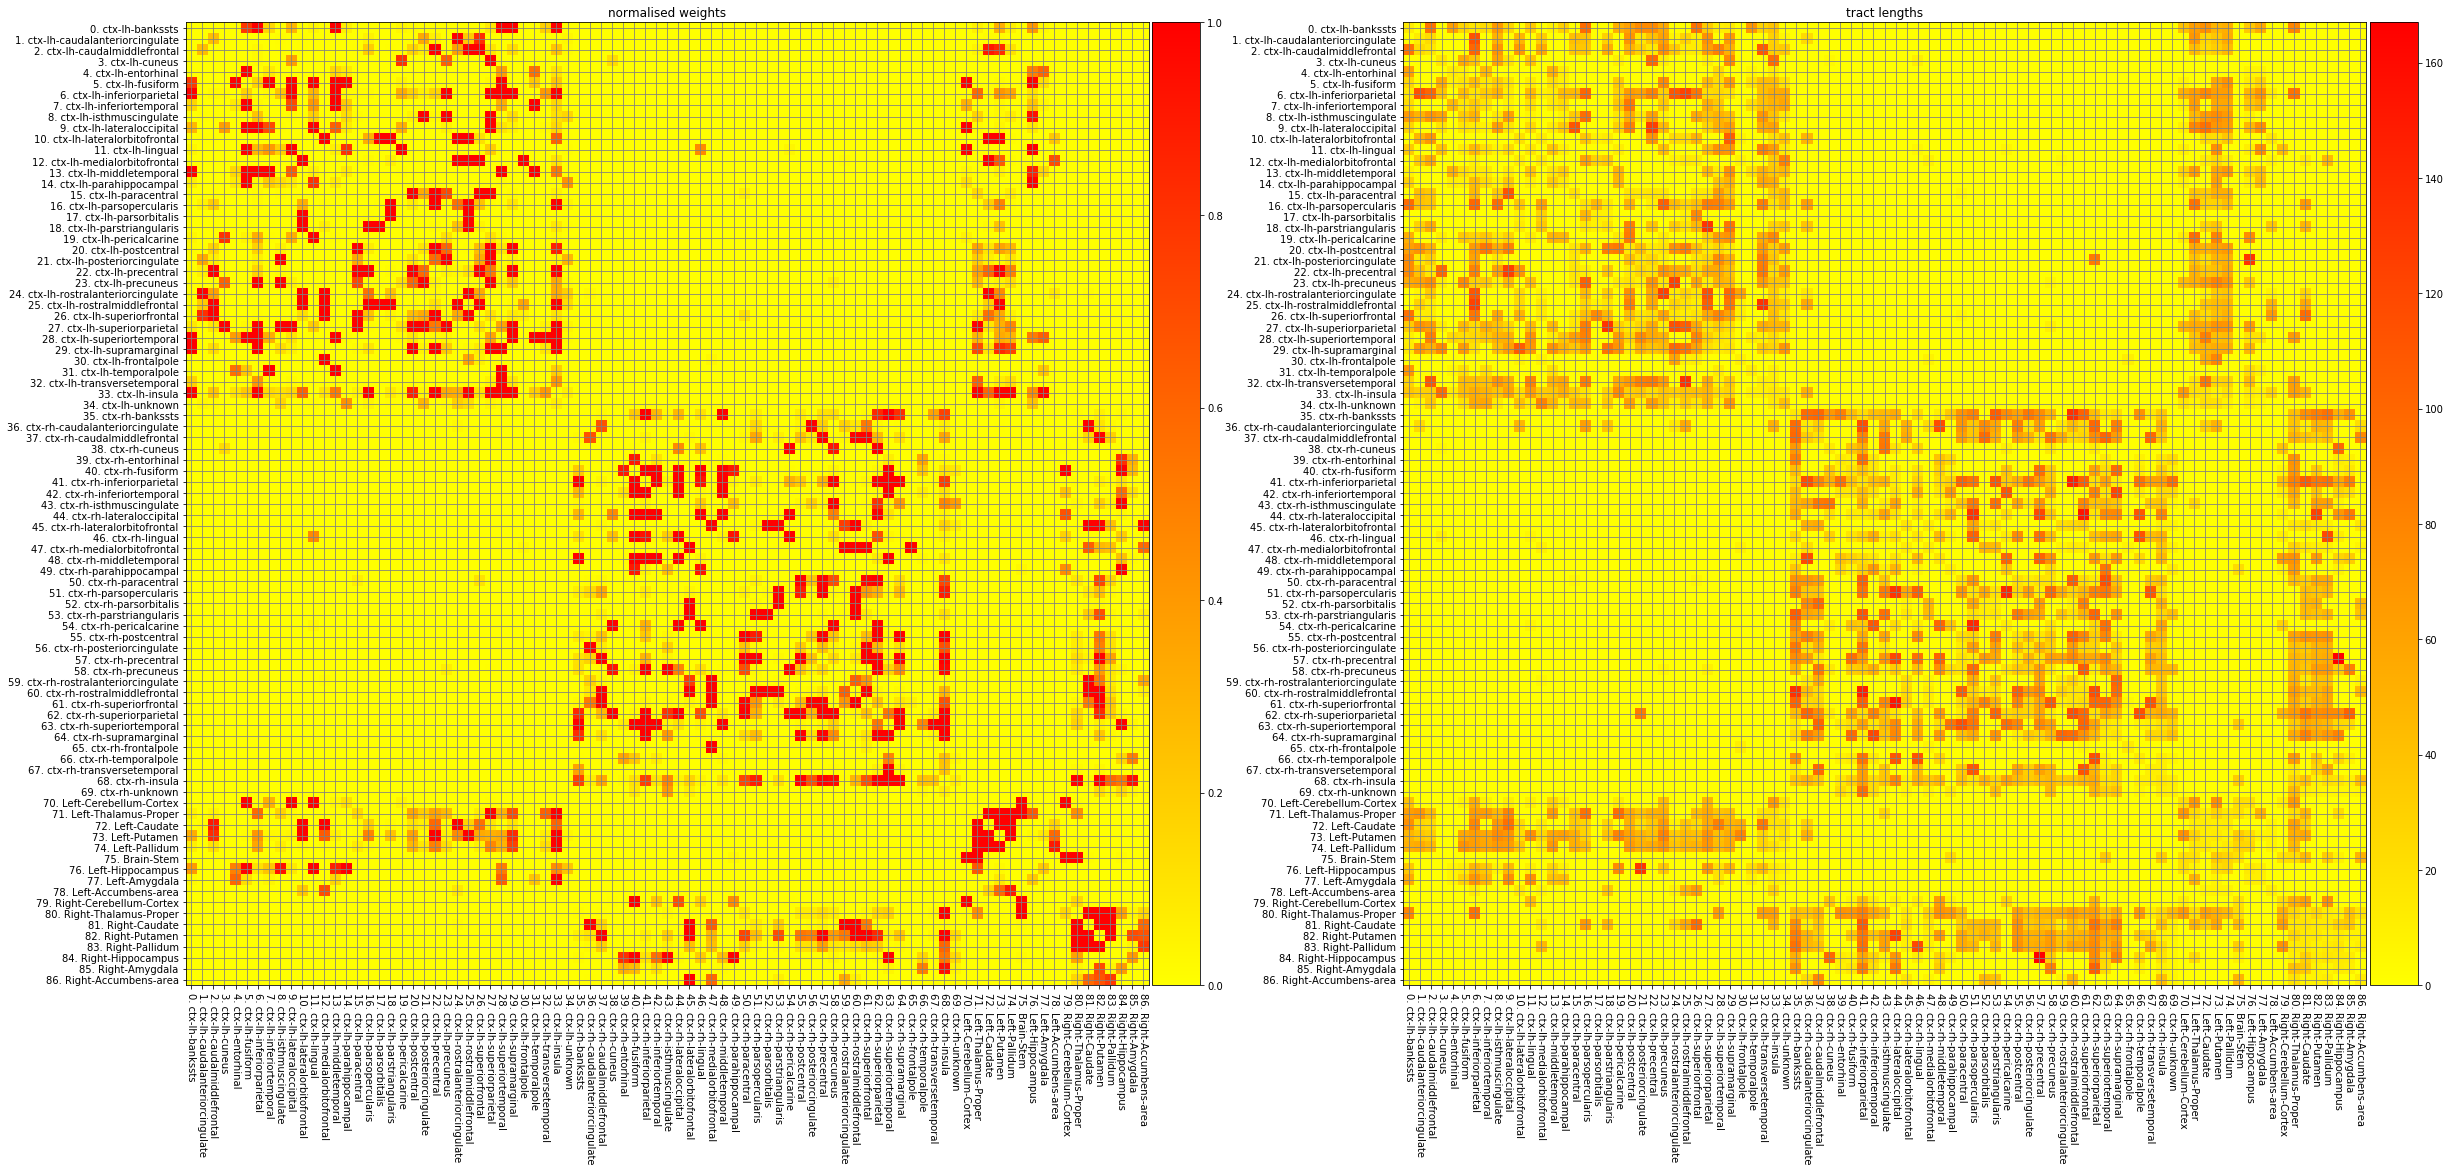

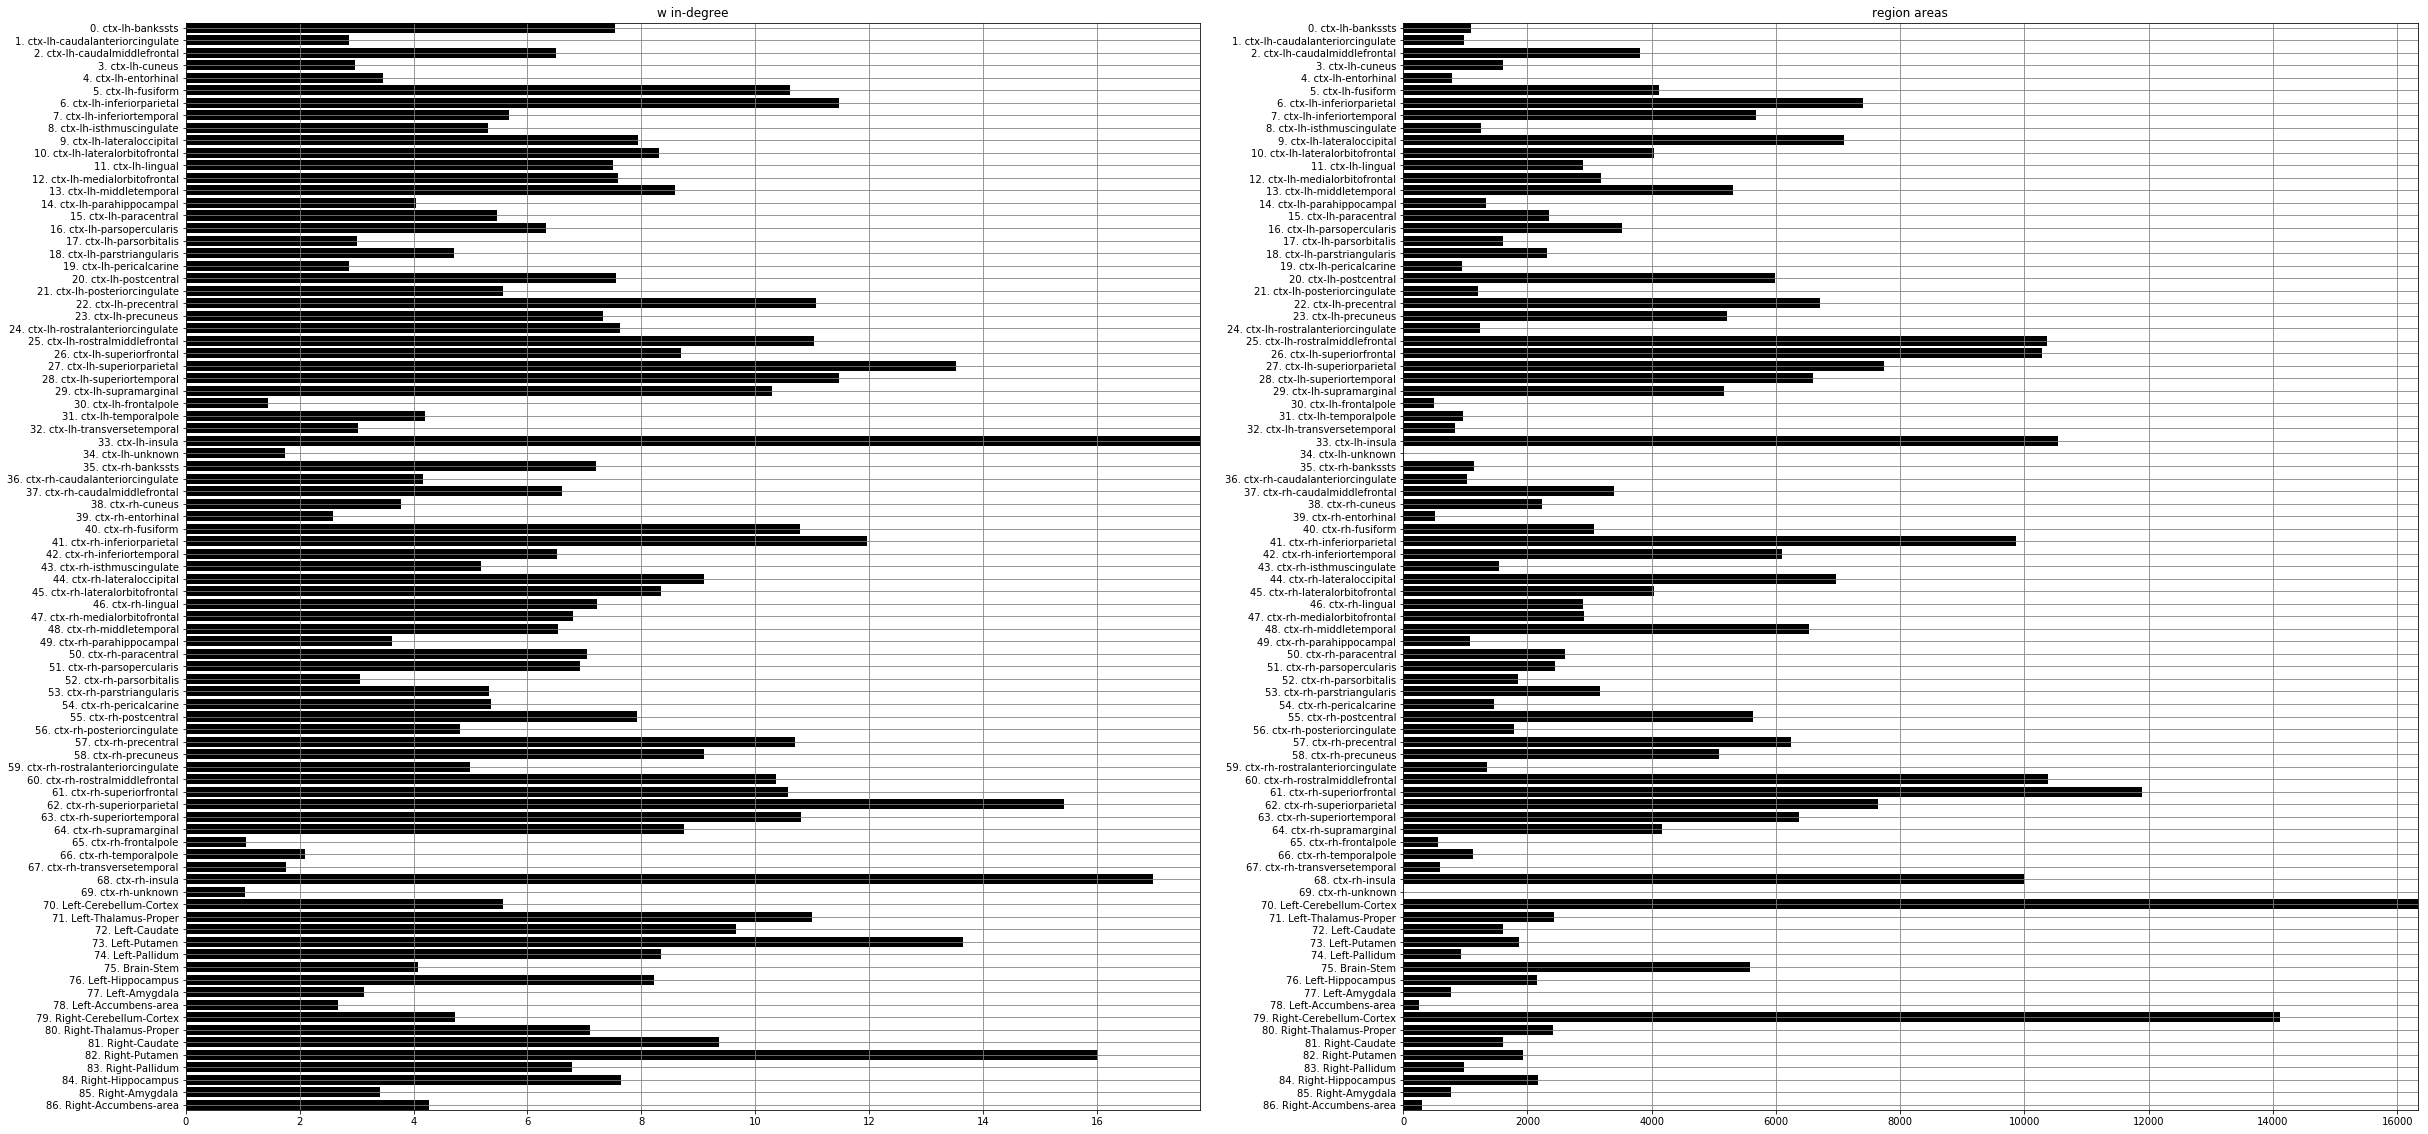

In [2]:
### Reading data
logger.info("Reading from: " + config.input.HEAD)
head = tvb_reader.read_head(config.input.HEAD)
# head = reader.read_head(config.input.HEAD)
# Plot
plotter.plot_head(head)

### Generate an hypothesis...

In [3]:
from tvb_epilepsy.service.hypothesis_builder import HypothesisBuilder
# Read clinical hypothesis... 
hyp_builder = HypothesisBuilder(head.connectivity.number_of_regions, config).set_normalize(0.95)

 ### ...by reading from epileptogenicity file

In [4]:
e_indices = []
hypothesis = hyp_builder.build_hypothesis_from_file("clinical_hypothesis_postseeg", e_indices)        


2018-02-22 11:01:22,236 - INFO - tvb_epilepsy.io.h5_reader - Starting to read Epileptogenicity from: /Users/dionperd/Dropbox/Work/VBtech/VEP/results/CC/TVB3/tvb/clinical_hypothesis_postseeg/clinical_hypothesis_postseeg.h5
2018-02-22 11:01:22,239 - INFO - tvb_epilepsy.io.h5_reader - Successfully read epileptogenicity values!


### ...or by manual definition 

In [ ]:
#...of formulate a VEP hypothesis manually
from tvb_epilepsy.service.hypothesis_builder import HypothesisBuilder

hyp_builder = HypothesisBuilder(head.connectivity.number_of_regions, config).set_normalize(0.95).

# Regions of Pathological Excitability hypothesis:
x0_indices = []
x0_values = []

# Regions of Model Epileptogenicity hypothesis:
e_indices = []
e_values = []

# Regions of Connectivity hypothesis:
w_indices = [] # use linear indices for the 2D connectivity matrix
w_values = [] # wij[w_linear_indice] *= w_value[w_linear_indice]
# hypo_builder.set_w_indices(w_indices).set_w_values(w_values)

hypothesis = hypo_builder.set_x0_hypothesis(x0_indices, x0_values).set_x0_hypothesis(e_indices, e_values).set_x0_hypothesis(w_indices, w_values).build_hypothesis()

### Print hypothesis

In [5]:
disease_indices = hypothesis.get_regions_disease_indices()
disease_values = hypothesis.get_regions_disease()
n_e = len(e_indices)
n_disease = len(disease_indices)
n_x0 = n_disease - n_e
all_regions_indices = np.array(range(head.number_of_regions))
healthy_indices = np.delete(all_regions_indices, disease_indices).tolist()
n_healthy = len(healthy_indices)
for iRegion in range(len(disease_indices)):
    print disease_indices[iRegion], ". ", head.connectivity.region_labels[disease_indices[iRegion]], disease_values[iRegion]
print(hypothesis)

1 .  ctx-lh-caudalanteriorcingulate 0.0
2 .  ctx-lh-caudalmiddlefrontal 0.947169363499
25 .  ctx-lh-rostralmiddlefrontal 0.298505425453
26 .  ctx-lh-superiorfrontal 0.0
DiseaseHypothesis{
01. Name = x0_Hypothesis
02. Type = Excitability
03. Number of regions = 87
04. X0 disease indices = [1, 2, 25, 26]
05. X0 disease values = [ 0.94716936  0.29850543  0.30292118  0.94999999]
06. e_values disease indices = []
07. e_values disease indices = []
08. Connectivity disease indices = []
09. Connectivity disease values = []
10. Propagation indices = []
11. Propagation strengths of indices = []}


In [ ]:
# Model configuration
from tvb_epilepsy.service.model_configuration_service import ModelConfigurationService

logger.info("\n\nCreating model configuration...")
model_configuration_service = ModelConfigurationService(hyp.number_of_regions)
model_configuration_service.write_to_h5(FOLDER_RES, hyp.name + "_model_config_service.h5")

model_configuration = model_configuration_service.configure_model_from_hypothesis(hyp, 
                                                                                  head.connectivity.normalized_weights)
model_configuration.write_to_h5(FOLDER_RES, hyp.name + "_ModelConfig.h5")

In [ ]:
# Run linear stability analysis
from tvb_epilepsy.service.lsa_service import LSAService

# Options for eigen_vectors_number: 
# "auto_eigenvals": eigenvalues curve elbow point selection,
# "auto_disease": len(n_disease), 
# "auto_epileptogenicity": Model Epileptogenicity curve elbow point selection,
# "auto_excitability": Pathological Excitability curve elbow point selection
# or "user_defined": a number equal to from 1 to hypothesis.number_of_regions
lsa_service = LSAService(eigen_vectors_number=None, 
                         eigen_vectors_number_selection="auto_eigenvals", 
                         weighted_eigenvector_sum=True)
lsa_hypothesis = lsa_service.run_lsa(hyp, model_configuration)

lsa_service.write_to_h5(FOLDER_RES, lsa_hypothesis.name + "_LSAConfig.h5")
lsa_hypothesis.write_to_h5(FOLDER_RES, lsa_hypothesis.name + "_LSA.h5")

# Plot
lsa_service.plot_lsa(lsa_hypothesis, model_configuration, head.connectivity.region_labels,  None, 
                     show_flag=SHOW_FLAG, save_flag=SAVE_FLAG, figure_dir=FOLDER_FIGURES, figure_format=FIG_FORMAT)

In [ ]:
# Run parameter search exploration for linear stability analysis around the clinical hypothesis

from tvb_epilepsy.base.utils import linear_index_to_coordinate_tuples, dicts_of_lists_to_lists_of_dicts, list_of_dicts_to_dicts_of_ndarrays
    
pse_params = {"path": [], "indices": [], "name": [], "samples": []}

# First sample the parameters of interest:
from tvb_epilepsy.service.sampling_service import StochasticSamplingService

# Some constants
n_samples=100
half_range = 0.1 
MAX_DISEASE_VALUE = 1.0 - 10 ** -3

# The connectivity matrix:
connectivity_matrix = head.connectivity.normalized_weights

# First build from the hypothesis the input parameters of the parameter search exploration.
# These can be either originating from excitability, epileptogenicity or connectivity hypotheses,
# or they can relate to the global coupling scaling (parameter K of the model configuration)

# Pathological Excitability
for ii in range(len(lsa_hypothesis.x0_values)):
    pse_params["indices"].append([ii])
    pse_params["path"].append("hypothesis.x0_values")
    pse_params["name"].append(str(head.connectivity.region_labels[lsa_hypothesis.x0_indices[ii]]) + " Excitability")

    # Now generate samples using a truncated uniform distribution (using inverse sampling with scipy)
    sampler = StochasticSamplingService(n_samples=n_samples, n_outputs=1, sampling_module="scipy",
                                        random_seed=None,
                                        trunc_limits={"high": MAX_DISEASE_VALUE},
                                        sampler="uniform",
                                        loc=lsa_hypothesis.x0_values[ii] - half_range, scale=2 * half_range)
    pse_params["samples"].append(sampler.generate_samples())

# Model Epileptogenicity
for ii in range(len(lsa_hypothesis.e_values)):
    pse_params["indices"].append([ii])
    pse_params["path"].append("hypothesis.e_values")
    pse_params["name"].append(str(head.connectivity.region_labels[lsa_hypothesis.e_indices[ii]]) + " Epileptogenicity")

    # Now generate samples using a truncated uniform distribution (using inverse sampling with scipy)
    sampler = StochasticSamplingService(n_samples=n_samples, n_outputs=1, sampling_module="scipy",
                                        random_seed=None,
                                        trunc_limits={"high": MAX_DISEASE_VALUE},
                                        sampler="uniform",
                                        loc=lsa_hypothesis.e_values[ii] - half_range, scale=2 * half_range)
    pse_params["samples"].append(sampler.generate_samples())

# Connectivity
for ii in range(len(lsa_hypothesis.w_values)):
    pse_params["indices"].append([ii])
    pse_params["path"].append("hypothesis.w_values")
    inds = linear_index_to_coordinate_tuples(lsa_hypothesis.w_indices[ii], connectivity_matrix.shape)
    if len(inds) == 1:
        pse_params["name"].append(str(region_labels[inds[0][0]]) + "-" +
                                    str(region_labels[inds[0][0]]) + " Connectivity")
    else:
        pse_params["name"].append("Connectivity[" + str(inds), + "]")

    # Now generate samples using a truncated normal distribution (using inverse sampling with scipy)
    sampler = StochasticSamplingService(n_samples=n_samples, n_outputs=1, sampling_module="scipy",
                                        random_seed=None,
                                        trunc_limits={"high": MAX_DISEASE_VALUE},
                                        sampler="norm", loc=lsa_hypothesis.w_values[ii], scale=half_range)
    pse_params["samples"].append(sampler.generate_samples())

# Global coupling
kloc = model_configuration_service.K_unscaled[0]
global_coupling = [{}]
for val in global_coupling:
    pse_params["path"].append("model.configuration.service.K_unscaled")
    inds = val.get("indices", all_regions_indices)
    if np.all(inds == all_regions_indices):
        pse_params["name"].append("Global coupling")
    else:
        pse_params["name"].append("Afferent coupling[" + str(inds) + "]")
    pse_params["indices"].append(inds)

    # Now generate samples susing a truncated normal distribution
    sampler = StochasticSamplingService(n_samples=n_samples, n_outputs=1, sampling_module="scipy",
                                        random_seed=None,
                                        trunc_limits={"low": 0.0}, sampler="norm", loc=kloc, scale=30 * half_range)
    pse_params["samples"].append(sampler.generate_samples())

# Convert to a list of dicts
pse_params_list = dicts_of_lists_to_lists_of_dicts(pse_params)

# Optionally, add a random jitter to the healthy regions Pathological Excitability...:
healthy_regions_parameters=[{}]
for val in healthy_regions_parameters:
    inds = val.get("indices", healthy_indices)
    name = val.get("name", "x0")
    n_params = len(inds)
    sampler = StochasticSamplingService(n_samples=n_samples, n_outputs=n_params, sampler="uniform",
                                        trunc_limits={"low": 0.0}, sampling_module="scipy",
                                        random_seed=None,
                                        loc=0.0, scale=2 * half_range)

    samples = sampler.generate_samples()
    for ii in range(n_params):
        pse_params_list.append({"path": "model_configuration_service." + name, "samples": samples[ii],
                                    "indices": [inds[ii]], "name": name})
        
# Now run pse:
from tvb_epilepsy.service.pse_service import PSEService
pse = PSEService("LSA", hypothesis=lsa_hypothesis, params_pse=pse_params_list)
pse_results, execution_status = pse.run_pse(connectivity_matrix, grid_mode=False, lsa_service_input=lsa_service,
                                            model_configuration_service_input=model_configuration_service)

# Convert results to a dict of numpy arrays:
pse_results = list_of_dicts_to_dicts_of_ndarrays(pse_results)

# Plot
lsa_service.plot_lsa(lsa_hypothesis, model_configuration, head.connectivity.region_labels, pse_results, 
                     show_flag=SHOW_FLAG, save_flag=SAVE_FLAG, figure_dir=FOLDER_FIGURES, figure_format=FIG_FORMAT)

# Write pse service and results to h5 files
pse.write_to_h5(FOLDER_RES, lsa_hypothesis.name + "_PSE_LSA_Service.h5")
convert_to_h5_model(pse_results).write_to_h5(FOLDER_RES, lsa_hypothesis.name + "_PSE_LSA_results.h5")



In [ ]:
# Simulation
from tvb_epilepsy.base.constants import ADDITIVE_NOISE, NOISE_SEED
from tvb_epilepsy.base.utils import calculate_projection
from tvb_epilepsy.base.computations.analyzers_utils import filter_data
from tvb_epilepsy.base.simulators import SimulationSettings
from tvb_epilepsy.base.plot_utils import plot_sim_results
from tvb_epilepsy.service.epileptor_model_factory import model_build_dict, model_noise_intensity_dict, model_noise_type_dict
from tvb_epilepsy.custom.read_write import write_ts_epi, write_ts_seeg_epi
from tvb_epilepsy.custom.simulator_custom import EpileptorModel
from tvb_epilepsy.tvb_api.simulator_tvb import SimulatorTVB
from tvb_epilepsy.tvb_api.epileptor_models import EpileptorDP2D, EpileptorDPrealistic, EpileptorDP2D

from tvb.datatypes import equations
from tvb.simulator import monitors, noise
from tvb.simulator.models import Epileptor
    
# Choose the model:
# other options: the TVB "Epileptor", 
# the 2D reduced model: "EpileptorDP2D", 
# a model to create realistic simulations: "EpileptorDPrealistic" 
# by coupling Iext2 and slope to the slow z variable + other pink noisy tricks...
model_name = "EpileptorDPrealistic" 
# and the variables of interest...
VOIS = {
    "JavaEpileptor": ['x1', 'z', 'x2'],
    "Epileptor": ['x1', 'y1', 'z', 'x2', 'y2', 'g', 'lfp'],
    "EpileptorDP": ['x1', 'y1', 'z', 'x2', 'y2', 'g', 'lfp'],
    "EpileptorDPrealistic": ['x1', 'y1', 'z', 'x2', 'y2', 'g', 'x0ts', 'slopeTS', 'Iext1ts', 'Iext2ts', 'Kts', 'lfp'],
    "EpileptorDP2D": ['x1', 'z']
}

# Projections computations: Get gain matrices for every available sensors' set

sensorsSEEG = []
projections = []
for sensors, projection in head.sensorsSEEG.iteritems():
    if projection is None:
        continue
    else:
        projection = calculate_projection(sensors, head.connectivity)
        head.sensorsSEEG[sensors] = projection
        sensorsSEEG.append(sensors)
        projections.append(projection)
        
# Simulation preparations regarding time scales
fs = 4096.0 # (in Hz), this is the simulation sampling rate that is necessary for the simulation to be stable
time_length = 100000.0  #in msec =100 secs, the final output nominal time length of the simulation
scale_time = 2.0 # scaling factor to accelerate  simulation to get the nominal time length in less integration steps
# scale_fsavg = 8.0 # scaling factor for the monitor period, it affects the final output sampling time
report_every_n_monitor_steps = 100.0
dt = 1000.0 / fs #(in msec)
scale_fsavg = int(np.round(fs / 512.0))
fsAVG = fs / scale_fsavg
monitor_period = scale_fsavg * dt / scale_time
sim_length = time_length / scale_time
time_length_avg = np.round(sim_length / monitor_period)
n_report_blocks = max(report_every_n_monitor_steps * np.round(time_length_avg / 100), 1.0)

# Filtering options:
hpf_flag = False # To high pass filter SEEG or not...
hpf_low = max(16.0, 1000.0 / time_length)  # msec
hpf_high = min(250.0, fsAVG)

# Prepare the model and the simulator:

# Create the model
model = model_build_dict[model_name](model_configuration, zmode=np.array("lin"))

# Set some parameters according to model:
if isinstance(model, Epileptor):
    model.tt *= scale_time * 0.25
    model.r = 0.0001
else:
    model.tau1 *= scale_time
    model.tau0 = 10000.0
    if isinstance(model, EpileptorDPrealistic):
        model.slope = 0.25
        model.pmode = np.array("z")
        
# Set monitor:
monitor_expressions = []
for i in range(model._nvar):
        monitor_expressions.append("y" + str(i))
if not (isinstance(model, EpileptorDP2D)):
       monitor_expressions.append("y3 - y0")
        
model.variables_of_interest = monitor_expressions
monitors_instance = monitors.TemporalAverage()
monitors_instance.period = monitor_period

# Set noise:
noise_intensity = model_noise_intensity_dict[model_name]
noise_type = model_noise_type_dict[model_name]
if noise_type is ADDITIVE_NOISE:
    noise_instance = noise.Additive(nsig=noise_intensity, random_stream=np.random.RandomState(seed=NOISE_SEED))
    noise_instance.configure_white(dt=dt)

else:
    eq = equations.Linear(parameters={"a": 1.0, "b": 0.0})
    noise_instance = noise.Multiplicative(ntau=10, nsig=noise_intensity, b=eq,
                                          random_stream=np.random.RandomState(seed=NOISE_SEED))
    noise_shape = noise_instance.nsig.shape
    noise_instance.configure_coloured(dt=dt, shape=noise_shape)
    
# Create simulator and its settings:
settings = SimulationSettings(simulated_period=sim_length, integration_step=dt, scale_time=scale_time,
                                  noise_preconfig=noise_instance, noise_type=noise_type,
                                  noise_intensity=noise_intensity, noise_ntau=noise_instance.ntau,
                                  monitors_preconfig=monitors_instance, monitor_type=monitors_instance._ui_name,
                                  monitor_sampling_period=monitor_period, monitor_expressions=monitor_expressions,
                                  variables_names=model.variables_of_interest)

simulator_instance = SimulatorTVB(head.connectivity, model_configuration, model, settings)

# At last configure and run simulation!:
simulator_instance.config_simulation()
logger.info("\n\nSimulating...")
ttavg, tavg_data, status = simulator_instance.launch_simulation(n_report_blocks)

# Write simulation settings to a h5 file:
convert_to_h5_model(simulator_instance.simulation_settings).write_to_h5(FOLDER_RES, lsa_hypothesis.name + "_Sim_Settings.h5")

if not status:
    warnings.warn("\nSimulation failed!")

else:

    tavg_data = tavg_data[:, :, :, 0]

    vois = VOIS[model_name]

    model = simulator_instance.model

    logger.info("\n\nSimulated signal return shape: %s", tavg_data.shape)
    logger.info("Time: %s - %s", scale_time * ttavg[0], scale_time * ttavg[-1])
    logger.info("Values: %s - %s", tavg_data.min(), tavg_data.max())

    time = scale_time * np.array(ttavg, dtype='float32')
    sampling_time = np.min(np.diff(time))

    # Pack results into a dictionary:
    vois_ts_dict = dict()
    for idx_voi, voi in enumerate(vois):
        vois_ts_dict[voi] = tavg_data[:, idx_voi, :].astype('f')

    # High pass filter, and compute SEEG:
    if isinstance(model, EpileptorDP2D):
        raw_data = np.dstack([vois_ts_dict["x1"], vois_ts_dict["z"], vois_ts_dict["x1"]])
        lfp_data = vois_ts_dict["x1"]

        for idx_proj, proj in enumerate(projections):
            vois_ts_dict['seeg%d' % idx_proj] = vois_ts_dict['z'].dot(proj.T)

    else:
        if isinstance(model, EpileptorModel):
            lfp_data = vois_ts_dict["x2"] - vois_ts_dict["x1"]

        else:
            lfp_data = vois_ts_dict["lfp"]

        raw_data = np.dstack([vois_ts_dict["x1"], vois_ts_dict["z"], vois_ts_dict["x2"]])

        for idx_proj, proj in enumerate(projections):
            vois_ts_dict['seeg%d' % idx_proj] = vois_ts_dict['lfp'].dot(proj.T)
            if hpf_flag:
                for i in range(vois_ts_dict['seeg'].shape[0]):
                    vois_ts_dict['seeg_hpf%d' % i][:, i] = filter_data(
                        vois_ts_dict['seeg%d' % i][:, i], hpf_low, hpf_high, fsAVG)
                    
    # Write files:
    write_ts_epi(raw_data, dt, lfp_data, FOLDER_RES, lsa_hypothesis.name + "_ts.h5")

    for i in range(len(projections)):
        write_ts_seeg_epi(vois_ts_dict['seeg%d' % i], dt, FOLDER_RES, lsa_hypothesis.name + "_ts.h5")

    vois_ts_dict['time'] = time
    vois_ts_dict['time_units'] = 'msec'
    
    # Optionally write a MATLAB file as well
    from scipy.io import savemat
    savemat(os.path.join(FOLDER_RES, lsa_hypothesis.name + "_ts.mat"), vois_ts_dict)

    # Plot results
    plot_sim_results(model, lsa_hypothesis.propagation_indices, lsa_hypothesis.name, head, vois_ts_dict, sensorsSEEG, hpf_flag, 
                     save_flag=SAVE_FLAG, show_flag=SHOW_FLAG, figure_dir=FOLDER_FIGURES, figure_format=FIG_FORMAT)
